# Making predictions over amazon recommendation dataset

## Predictions
The purpose of this analysis is to make up a prediction model where we will be able to predict whether a recommendation is positive or negative. In this analysis, we will not focus on the Score, but only the positive/negative sentiment of the recommendation. 

To do so, we will work on Amazon's recommendation dataset, we will build a Term-doc incidence matrix using term frequency and inverse document frequency ponderation. When the data is ready, we will load it into predicitve algorithms. In the end, we hope to find a "best" model for predicting the recommendation's sentiment.

## Loading the data
As we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "postive". Otherwise, it will be set to "negative". 

The data will be split into an training set and a test set with a test set ratio of 0.2

In [68]:
import pandas as pd
import numpy as np
import pickle

In [69]:
df = pd.read_csv('Reviews.csv')

In [70]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [71]:
df.shape # data shape

(6263, 10)

In [72]:
df.nunique() # check num of unique items per column

Id                        6263
ProductId                  997
UserId                    5994
ProfileName               5821
HelpfulnessNumerator        49
HelpfulnessDenominator      52
Score                        5
Time                      1744
Summary                   5672
Text                      6239
dtype: int64

In [73]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [74]:
# rename columns HelpfulnessNumerator and HelpfulnessDenominator
df.columns = ["Id", "ProductId", "UserId", "ProfileName", "VotesHelpful",
              "VotesTotal", "Score", "Time", "Summary", "Text"]

Let's add the **Sentiment** column that turns the numeric score into either *positive* or *negative*.

Similarly, the **Usefulness** column turns the number of votes into a boolean.

In [75]:
df["Sentiment"] = df["Score"].apply(lambda score: "positive" if score > 3 else "negative")
df.head(5)

,Id,ProductId,UserId,ProfileName,VotesHelpful,VotesTotal,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


In [76]:
# check some statistics
print(df['Sentiment'].value_counts())

Sentiment
positive    4861
negative    1402
Name: count, dtype: int64


Select subcolumns

In [77]:
df = df[["Score", "Sentiment", "Summary", "Text"]]

Let's have a look at some 5s:

In [78]:
df[df.Score == 5].head(10)

,Score,Sentiment,Summary,Text
0,5,positive,Good Quality Dog Food,I have bought several of the Vitality canned d...
4,5,positive,Great taffy,Great taffy at a great price. There was a wid...
6,5,positive,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,5,positive,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,5,positive,Yay Barley,Right now I'm mostly just sprouting this so my...
9,5,positive,Healthy Dog Food,This is a very healthy dog food. Good for thei...
10,5,positive,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
11,5,positive,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...
14,5,positive,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...
15,5,positive,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...


And some 1s as well:

In [79]:
df[df.Score == 1].head(10)

,Score,Sentiment,Summary,Text
1,1,negative,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
12,1,negative,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...
26,1,negative,Nasty No flavor,"The candy is just red , No flavor . Just plan..."
50,1,negative,Don't like it,"This oatmeal is not good. Its mushy, soft, I d..."
62,1,negative,stale product.,Arrived in 6 days and were so stale i could no...
73,1,negative,Warning! WARNING! -ALCOHOL SUGARS!,Buyer Beware Please! This sweetener is not for...
75,1,negative,No Tea Flavor,No tea flavor at all. Just whole brunch of art...
99,1,negative,Bad,I fed this to my Golden Retriever and he hated...
153,1,negative,Rip off Price,These singles sell for $2.50 - $3.36 at the st...
164,1,negative,Tasteless but low calorie,Seriously this product was as tasteless as the...


## Cleaning the data

To format our data and build the Term-doc incidence matrix, many operations will be performed on the data :

- Stop words removal
- Stemming
- Punctuations
- Lowering

### Stopwords
* A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

![alt text](https://www.geeksforgeeks.org/wp-content/uploads/Stop-word-removal-using-NLTK.png)

## So we will not use stopwords removal for our modeling. 

### stemming

In [81]:
from nltk.stem import SnowballStemmer # Stemmers remove morphological affixes from words, leaving only the word stem.
snow = SnowballStemmer('english') 
print(snow.stem('tasty'))
print(snow.stem('joined'))
print(snow.stem('apples'))

tasti
join
appl


### Punctuations Removal

In [82]:
import re
# cleaning punctuations from the sentence
sentence = "I'd like to have some coffee today!"
sentence = re.sub(r'[\'|"|#]', r'', sentence) # remove these punctuation
sentence = re.sub(r'[?|!|.|,|)|(|\|/]',r' ',sentence) # replace these punctuation with space
sentence

'Id like to have some coffee today '

### combine

In [83]:
def cleanup(sentence):
    sentence = str(sentence)
    sentence = sentence.lower() # lower case
    sentence = re.sub(r'[?|!|.|,|)|(|\|/]',r' ',sentence) # replace these punctuation with space
    tokens = sentence.split()
    out = []
    for t in tokens:
        out.append(snow.stem(t))
    out = " ".join(out)
    out = re.sub(r'[\'|"|#]', r'', out) # remove these punctuation
    return out    

In [ ]:
# note that in this example, we do not use stopwords removal. 
# b/c stopwords like 'not', "hadn't" for example, have strong negative signal. 

In [84]:
print(cleanup("how are you today?"))
print(cleanup("Not as Advertised"))
print(cleanup(6))

how are you today
not as advertis
6


In [85]:
df["Summary_Clean"] = df["Summary"].apply(cleanup)

### Let's get fancy with WordClouds!

In [86]:
!pip install wordcloud
!pip install matplotlib

  Using cached wordcloud-1.9.3-cp311-cp311-macosx_10_9_x86_64.whl.metadata (3.4 kB)
Using cached wordcloud-1.9.3-cp311-cp311-macosx_10_9_x86_64.whl (172 kB)


In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=None,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

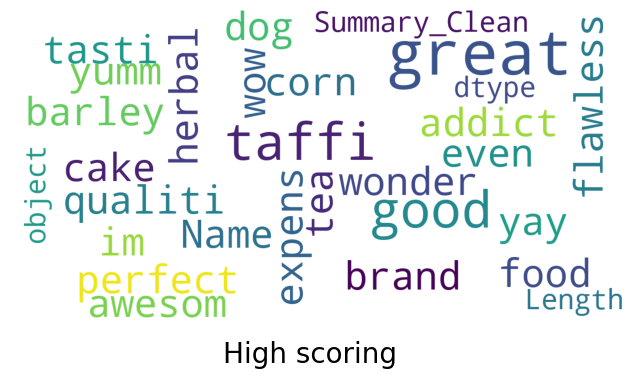

In [88]:
show_wordcloud(df.Summary_Clean.loc[df.Score == 5], title = "High scoring")

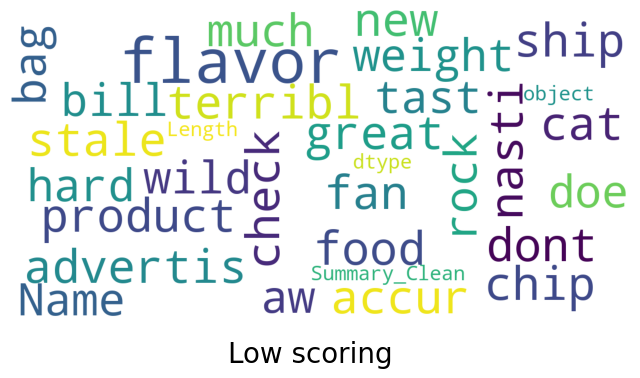

In [89]:
show_wordcloud(df.Summary_Clean.loc[df.Score == 1], title = "Low scoring")

### train test split

In [90]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state = 1)
print("%d items in training data, %d in test data" % (len(train), len(test)))

5010 items in training data, 1253 in test data


In [91]:
train = train.reset_index(drop=True)
train.head()

,Score,Sentiment,Summary,Text,Summary_Clean
0,1,negative,Please Think Twice...,Please think twice about purchasing this produ...,pleas think twice
1,5,positive,If you love strong full flavored coffee---this...,"If you like strong coffee, this is it! The fl...",if you love strong full flavor coffee---thi is...
2,5,positive,pancake/waffle mix,This was the best pancake/waffle mix ever! Won...,pancak waffl mix
3,4,positive,Very tasty biscuits!,Ok--I just bought BIsquick GF and the first th...,veri tasti biscuit
4,4,positive,Pschologically better than peanuts,Somehow I feel healtier eating these things in...,pscholog better than peanut


In [92]:
test = test.reset_index(drop=True)
test.head()

,Score,Sentiment,Summary,Text,Summary_Clean
0,5,positive,Great Price for a Great Product!,I'm constantly trying to find vanilla beans at...,great price for a great product
1,5,positive,Are We Reviewing Our Mistakes Or These Cookies?,"Wow. So far, two two-star reviews. One obvio...",are we review our mistak or these cooki
2,5,positive,All Natural Licorice Can't be beat,I have been eating Panda Licorice for a number...,all natur licoric cant be beat
3,5,positive,MC CORMICKS ALFREDO SAUCE,THANKS TO AMAZON FOR CARRYING THIS WONDERFUL P...,mc cormick alfredo sauc
4,5,positive,Good stuff,I had bought Pocky when on vacation and enjoye...,good stuff


# Ways to convert text to vector
## *1) Uni-gram BOW*

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
train['Summary_Clean'].values

array(['the best espresso iv ever had', 'fals advertis but tasti',
       'dead treat', ..., 'best waffel mix ever', 'tri it youll love it',
       'not worth the money'], dtype=object)

In [ ]:
uni_gram = CountVectorizer(min_df = 5, binary = True) # only use keyword which shows up more than 5 times. 
uni_gram_vectors_train = uni_gram.fit_transform(train['Summary_Clean'].values)
uni_gram_vectors_test = uni_gram.transform(test['Summary_Clean'].values)

In [ ]:
uni_gram_vectors_train.shape

(454763, 8208)

In [ ]:
uni_gram_vectors_train[0]

<1x8208 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [ ]:
type(uni_gram_vectors_train)

scipy.sparse.csr.csr_matrix

## *2) Bi-gram BOW*

In [ ]:
bi_gram = CountVectorizer(ngram_range=(1,2), min_df = 5, binary = True) # 1 means the minimum is unigram, 2 means max is bigrams, 
bi_gram_vectors_train = bi_gram.fit_transform(train['Summary_Clean'].values)
bi_gram_vectors_test = bi_gram.transform(test['Summary_Clean'].values)


In [ ]:
bi_gram_vectors_train.shape

(454763, 46995)

In [ ]:
features = bi_gram.get_feature_names()
features[-20:]

['zoe oliv',
 'zoe organ',
 'zola',
 'zombi',
 'zone',
 'zoo',
 'zoom',
 'zot',
 'zotz',
 'zsweet',
 'zuke',
 'zuke chicken',
 'zuke dad',
 'zuke dog',
 'zuke hip',
 'zuke is',
 'zuke mini',
 'zuke peanut',
 'zuke product',
 'zuke treat']

## *3) tf-idf*

* TF*IDF is an information retrieval technique that weighs a term's frequency (TF) and its inverse document frequency (IDF). Each word or term has its respective TF and IDF score. The product of the TF and IDF scores of a term is called the TF*IDF weight of that term

![alt text](https://1.bp.blogspot.com/-tnzPA6dDtTU/Vw6EWm_PjCI/AAAAAAABDwI/JatHtUJb4fsce9E-Ns5t02_nakFtGrsugCLcB/s1600/%25E8%259E%25A2%25E5%25B9%2595%25E5%25BF%25AB%25E7%2585%25A7%2B2016-04-14%2B%25E4%25B8%258A%25E5%258D%25881.39.07.png)

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df = 5)
tfidf_vectors_train = tfidf.fit_transform(train['Summary_Clean'].values)
tfidf_vectors_test = tfidf.transform(test['Summary_Clean'].values)

In [94]:
tfidf_vectors_train.shape

(5010, 922)

In [95]:
features = tfidf.get_feature_names_out()
features[0:10]

array(['100', '100 calori', '12', 'about', 'absolut', 'absolut delici',
       'acid', 'ad', 'add', 'addict'], dtype=object)

In [96]:
prediction = dict()
prob = dict()

## Applying Logistic regression learning method

In [26]:
from sklearn.linear_model import LogisticRegression

In [30]:
logreg_tfidf = LogisticRegression(C = 1e5, class_weight = 'balanced')
logreg_tfidf_result = logreg_tfidf.fit(tfidf_vectors_train, train['Sentiment'])
# logreg_bi_gram = pickle.load(open('amazon.lr.pickle', 'rb'))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
prediction['logistic_tfidf'] = logreg_tfidf.predict(tfidf_vectors_test)

In [34]:
prediction['logistic_tfidf']

array(['positive', 'positive', 'positive', ..., 'negative', 'negative',
       'positive'], dtype=object)

In [35]:
import collections
print('test data')
print(test['Sentiment'].value_counts())
print('--------------')
print('predicted data')
print(collections.Counter(prediction['logistic_tfidf']))

test data
Sentiment
positive    977
negative    276
Name: count, dtype: int64
--------------
predicted data
Counter({'positive': 869, 'negative': 384})


In [36]:
prob['logistic_tfidf'] = logreg_tfidf.predict_proba(tfidf_vectors_test)

In [37]:
prob['logistic_tfidf'][:,1]

array([0.99860481, 0.99960712, 0.9994581 , ..., 0.46806971, 0.26645003,
       1.        ])

## Results

In order to compare our learning algorithms, let's build the ROC curve. The curve with the highest AUC value will show our "best" algorithm.

In [38]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

In [40]:
import matplotlib.pyplot as plt

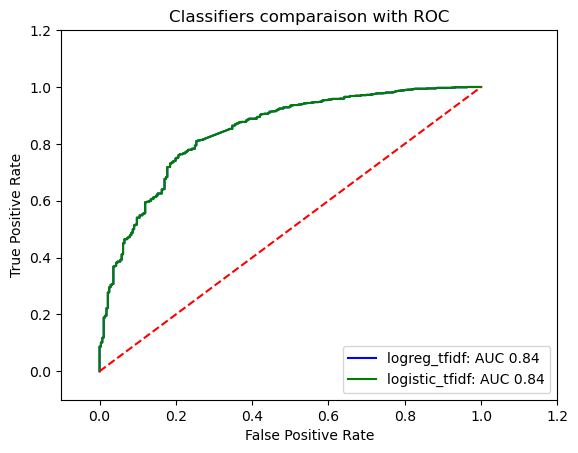

In [41]:
cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = \
            roc_curve(test['Sentiment'].values, prob['logistic_tfidf'][:,1], pos_label = 'positive')
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [42]:
print(metrics.classification_report(test['Sentiment'].values, 
                                    prediction['logistic_tfidf'], 
                                    target_names = ["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.53      0.73      0.61       276
    positive       0.91      0.81      0.86       977

    accuracy                           0.80      1253
   macro avg       0.72      0.77      0.74      1253
weighted avg       0.83      0.80      0.81      1253



Let's remember what Precision and Recall are (more here https://en.wikipedia.org/wiki/Precision_and_recall)

![Precision_Recall](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png)

In [ ]:
# recall and precision are low for negative class. More improvement can be made. 

### Let's also have a look at what the best & words are by looking at the coefficients:

In [44]:
feature = tfidf.get_feature_names_out()
feature_coefs = pd.DataFrame(
    data = list(zip(feature, logreg_tfidf.coef_[0])),
    columns = ['feature', 'coef'])

feature_coefs.sort_values(by='coef')

,feature,coef
507,meh,-61.690277
453,just ok,-45.947439
741,stash,-41.896236
95,bewar,-41.209303
389,hate,-41.047084
...,...,...
658,quit,42.784608
257,excel,45.517299
181,crisp,46.461768
9,addict,50.742360


## Applying RandomForest method

In [97]:
from sklearn.ensemble import RandomForestClassifier

In [98]:
rf_tfidf = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', n_jobs = -1)
rf_tfidf_result = rf_tfidf.fit(tfidf_vectors_train, train['Sentiment'])
#rf_tfidf = pickle.load(open('amazon.rf.pickle', 'rb'))

In [99]:
prediction['rf_tfidf'] = rf_tfidf.predict(tfidf_vectors_test)

In [100]:
print('test data')
print(test['Sentiment'].value_counts())
print('--------------')
print('predicted data')
print(collections.Counter(prediction['rf_tfidf']))

test data
Sentiment
positive    977
negative    276
Name: count, dtype: int64
--------------
predicted data
Counter({'positive': 962, 'negative': 291})


In [101]:
prob['rf_tfidf'] = rf_tfidf.predict_proba(tfidf_vectors_test)
prob['rf_tfidf'][0:10,1]

array([0.92      , 0.66330937, 0.90415298, 0.9544652 , 1.        ,
       0.76      , 1.        , 0.98840325, 0.13      , 0.89035628])

In [102]:
test['Sentiment'][0:10]

0    positive
1    positive
2    positive
3    positive
4    positive
5    positive
6    positive
7    positive
8    negative
9    positive
Name: Sentiment, dtype: object

In [103]:
import matplotlib.pyplot as plt

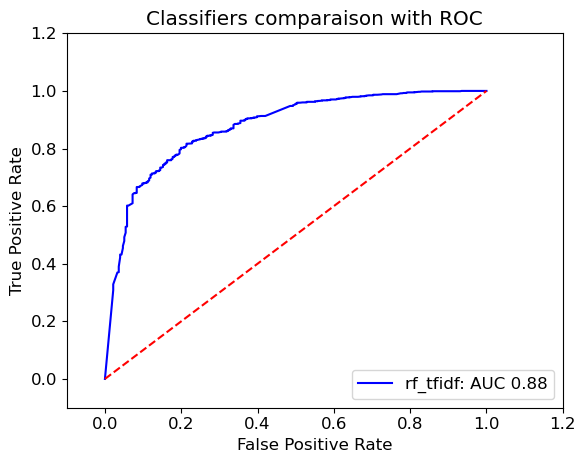

In [104]:
cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = \
            roc_curve(test['Sentiment'].values, prob[model][:,1], pos_label = 'positive')
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [106]:
print(metrics.classification_report(test['Sentiment'].values, 
                                    prediction['rf_tfidf'], 
                                    target_names = ["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.62      0.65      0.63       276
    positive       0.90      0.89      0.89       977

    accuracy                           0.83      1253
   macro avg       0.76      0.77      0.76      1253
weighted avg       0.84      0.83      0.84      1253



### Let's also have a look at what the best & words are by looking at the importance score:

In [109]:
feature = tfidf.get_feature_names_out()
rf_feature_importance = pd.DataFrame(data = list(zip(feature, rf_tfidf.feature_importances_)),
    columns = ['feature', 'importance'])
rf_feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
552,not,5.985622e-02
346,great,5.312162e-02
77,best,3.055334e-02
322,good,2.235260e-02
485,love,2.231602e-02
...,...,...
82,best dog,8.650530e-07
383,hand,6.889577e-07
730,son love,6.516940e-07
92,best waffl,6.046336e-07


Visualize feature importance

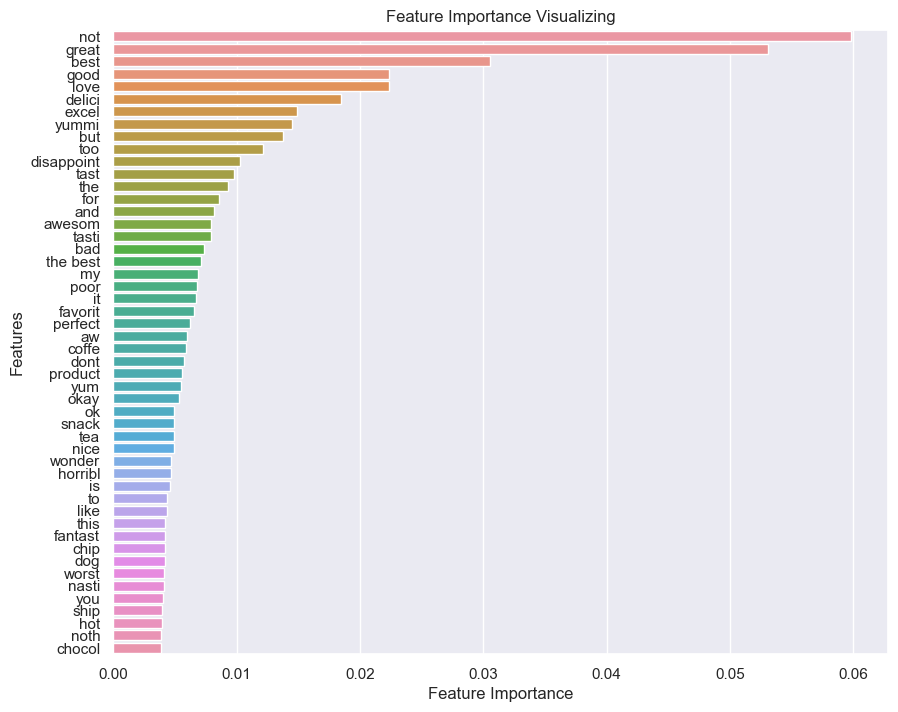

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
feature_importance=pd.Series(rf_tfidf.feature_importances_,index=feature).sort_values(ascending=False)
top_features=feature_importance.nlargest(50)
sns.set(rc={'figure.figsize':(10,8)})
sns.barplot(x=top_features,y=top_features.index)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Visualizing")
plt.show()

In [108]:
pickle.dump(logreg_tfidf, open('amazon.lr.pickle', 'wb'))
pickle.dump(rf_tfidf, open('amazon.rf.pickle', 'wb'))    

# logreg_bi_gram = pickle.load(open('amazon.lr.pickle', 'rb'))
# rf_bi_gram = pickle.load(open('amazon.rf.pickle', 'rb'))


## next step
- try tfidf
- try using Logistic regression + L1 regularization
- try other machine learning methods. 

XGBoost

In [115]:
import xgboost as xgb

In [119]:
# Import necessary library
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you already have tfidf_vectors_train, tfidf_vectors_test, train, and test data prepared

# Replace string labels with integers
train['Sentiment'] = train['Sentiment'].replace({'negative': 0, 'positive': 1})
test['Sentiment'] = test['Sentiment'].replace({'negative': 0, 'positive': 1})

# Initialize the model
mdl = xgb.XGBClassifier(
    learning_rate=0.05,
    n_estimators=500,
    max_depth=3,
    subsample=0.8,
    objective='binary:logistic',
    monotone_constraints="1",
    nthread=-1
)

# Fit the model
mdl.fit(tfidf_vectors_train, train['Sentiment'])

# Predictions
pred = mdl.predict(tfidf_vectors_test)
pred_proba = mdl.predict_proba(tfidf_vectors_test)

# Evaluation
confusionmat = confusion_matrix(test['Sentiment'], pred)
print("Classification Report:")
print(classification_report(test['Sentiment'], pred))
print("Confusion Matrix:")
print(confusionmat)


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.34      0.47       276
           1       0.84      0.97      0.90       977

    accuracy                           0.83      1253
   macro avg       0.79      0.66      0.69      1253
weighted avg       0.82      0.83      0.80      1253

Confusion Matrix:
[[ 95 181]
 [ 32 945]]


In [121]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assuming pred_proba and the test labels are available from the previous code
# The provided code does not specify variable names for test labels or the predicted probabilities,
# so I'll use placeholder variables: test_labels for the true class labels and pred_proba for the predicted probabilities.
# pred_proba[:, 1] should contain the probabilities for the positive class.

# True class labels
# Replace `test_labels` with the actual variable name for the true class labels from the test set
test_labels = test['Sentiment'].values

# Predicted probabilities for the positive class
# Replace `pred_proba` with the actual variable name for the predicted probabilities for the positive class
predicted_probabilities = pred_proba[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(test_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Print AUC
print(f"AUC: {roc_auc}")


AUC: 0.8556565499236053


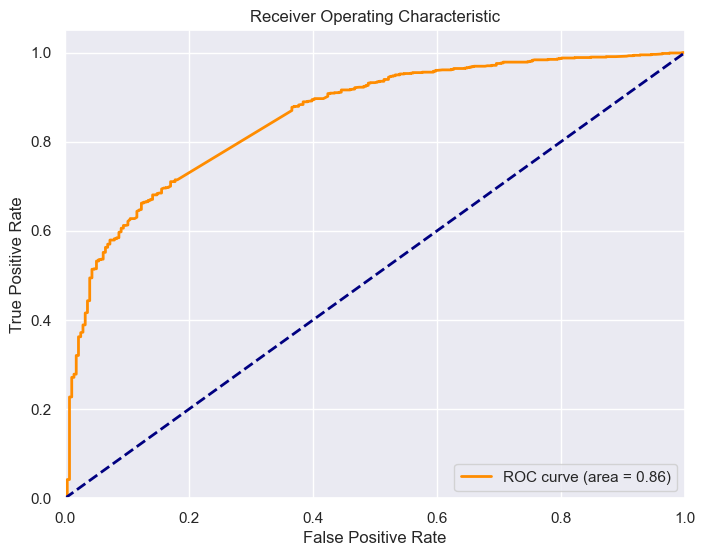

AUC: 0.8556565499236053


In [125]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# I'll assume that 'test' and 'pred_proba' are already defined in your context as they appear in your code.

# Assuming pred_proba and the test labels are available from the previous code
# True class labels
# You should replace `test['Sentiment'].values` with the actual way to access your test labels
test_labels = test['Sentiment'].values

# Predicted probabilities for the positive class
# Ensure that `pred_proba[:, 1]` correctly indexes the probabilities for the positive class
predicted_probabilities = pred_proba[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(test_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print AUC
print(f"AUC: {roc_auc}")




LDA

In [ ]:
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words=list(sent_to_words(sentences))
print(data_words[:1])